In [58]:
import sys
from datetime import datetime, timezone, timedelta
import torch as th
from stable_baselines3 import DQN

sys.path.append("../airflow/plugins")

from db_connection import DbConnection
from domain_model import Instrument, Interval
from gym_env_single_asset import register_single_asset_trading_env 
from candles_sql_adapter import CandlesSqlAdapter
from strategy_basic import StrategyRandomWalk, StrategyTrendFollowing
from strategy_sb3 import StrategySb3
from evaluation.strategy_evaluator import StrategyEvaluator

In [59]:
register_single_asset_trading_env(1)
db_connection = DbConnection.local_db_connection()
instrument = Instrument.get_instrument("SBER")
interval = Interval.hour_1
device = th.device("cuda" if th.cuda.is_available() else "cpu")
sql_adapter = CandlesSqlAdapter(db_connection, interval, instrument)

In [60]:
end_time_utc = datetime(2024, 12, 5, tzinfo=timezone.utc)
start_time_utc = end_time_utc - timedelta(days=60)
commission = 0.0

In [61]:
model = DQN.load("models/dqn_model.zip")
sb3_strategy = StrategySb3(model)
s3_evaluator = StrategyEvaluator(sql_adapter, sb3_strategy)
sb3_df = s3_evaluator.evaluate(start_time_utc, end_time_utc, commission)
#sb3_df["profit_cum"].plot()

In [62]:
rw_strategy = StrategyRandomWalk()
rw_evaluator = StrategyEvaluator(sql_adapter, rw_strategy)
rw_df = rw_evaluator.evaluate(start_time_utc, end_time_utc, commission)
#rw_df["profit_cum"].plot()

In [63]:
from feature_composer import FeatureComposer
from gym_env_single_asset import SingleAssetTrading
feature_composer = FeatureComposer(sql_adapter, fill_missing_values=False)
candles = feature_composer.compose(start_time_utc, end_time_utc)
threshold = SingleAssetTrading.get_threshold(candles)

tf_strategy = StrategyTrendFollowing(price_delta_threshold=threshold)
tf_evaluator = StrategyEvaluator(sql_adapter, tf_strategy)
tf_df = tf_evaluator.evaluate(start_time_utc, end_time_utc, commission)
#tf_df["profit_percent_cum_with_comission"].plot()

In [64]:
sb3_df.rename(columns={"profit_percent_cum_with_comission": "DQN"}, inplace=True)
sb3_df = sb3_df[["DQN"]]
#sb3_df


In [65]:
rw_df.rename(columns={"profit_percent_cum_with_comission": "random_walk"}, inplace=True)
rw_df = rw_df[["random_walk"]]
#rw_df


In [66]:
tf_df.rename(columns={"profit_percent_cum_with_comission": "trend_follow"}, inplace=True)
tf_df = tf_df[["trend_follow"]]
#tf_df


<Axes: title={'center': 'Strategy comparison (%) in 60 days SBER'}, xlabel='time_utc'>

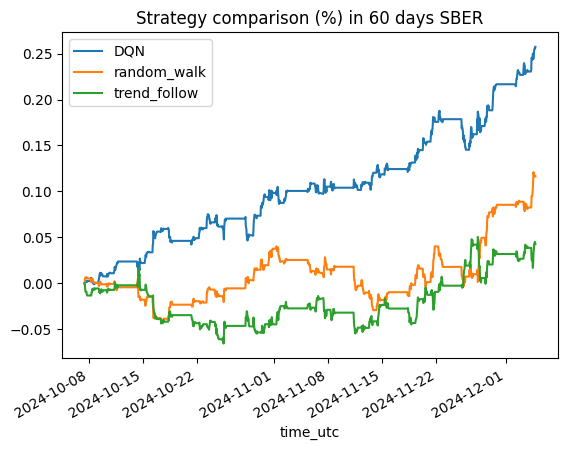

In [67]:
benchmark = sb3_df.join([rw_df, tf_df], sort=True)
benchmark.plot(title="Strategy comparison (%) in 60 days SBER")